# Predição HRTF com Random Forest

Implementação usando parâmetros antropométricos da cabeça e orelha.
Baseado em: Teng & Zhong (2023)

## 1. Importação das bibliotecas

In [1]:
# Bibliotecas necessárias
import os
import re
import glob
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Seed para reproduzir resultados
np.random.seed(42)

# Caminho dos dados
data_dir = "data/hutubs"
print(f"Diretório de dados: {data_dir}")

/home/augusto/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Diretório de dados: data/hutubs


## 2. Carregamento dos dados antropométricos

In [2]:
# Leitura do arquivo CSV
csv_file = os.path.join(data_dir, "AntrhopometricMeasures.csv")
df = pd.read_csv(csv_file)
df.columns = [c.strip() for c in df.columns]
df["SubjectID"] = df["SubjectID"].astype(int)

print(f"Total de sujeitos: {len(df)}")
print(f"Parâmetros disponíveis: {len(df.columns) - 1}")

Total de sujeitos: 96
Parâmetros disponíveis: 37


## 3. Criação das features

In [3]:
# Função para criar features de cada orelha
def create_features_for_ear(df, ear='L'):
    features = pd.DataFrame()
    features['SubjectID'] = df['SubjectID']
    
    # Parâmetros da cabeça
    features['x1'] = df['x1']  # largura
    features['x2'] = df['x2']  # altura
    features['x3'] = df['x3']  # profundidade
    features['x4'] = df['x4']  # offset pinna vertical
    features['x5'] = df['x5']  # offset pinna horizontal
    features['x16'] = df['x16']  # circunferência
    
    # Parâmetros da orelha
    prefix = 'L_' if ear == 'L' else 'R_'
    features['d1'] = df[f'{prefix}d1']
    features['d2'] = df[f'{prefix}d2']
    features['d3'] = df[f'{prefix}d3']
    features['d4'] = df[f'{prefix}d4']
    features['d5'] = df[f'{prefix}d5']
    features['d6'] = df[f'{prefix}d6']
    features['d7'] = df[f'{prefix}d7']
    features['d8'] = df[f'{prefix}d8']
    features['d9'] = df[f'{prefix}d9']
    features['d10'] = df[f'{prefix}d10']
    features['theta1'] = df[f'{prefix}theta1']
    features['theta2'] = df[f'{prefix}theta2']
    
    # Cálculo das áreas
    features['area_cavum'] = features['d1'] * features['d3'] / 2
    features['area_cymba'] = features['d2'] * features['d3'] / 2
    features['area_fossa'] = features['d4'] * features['d6'] / 2
    features['area_pinna'] = features['d5'] * features['d6'] / 2
    features['area_intertragal'] = features['d7'] * (features['d1'] + features['d3']) / 2
    
    return features

# Criar datasets para cada orelha
df_left = create_features_for_ear(df, 'L')
df_right = create_features_for_ear(df, 'R')

# Remover sujeitos com dados faltando
df_left = df_left.dropna()
df_right = df_right.dropna()

feature_cols = [col for col in df_left.columns if col != 'SubjectID']
print(f"Sujeitos válidos: {len(df_left)}")
print(f"Total de features: {len(feature_cols)}")

Sujeitos válidos: 93
Total de features: 23


## 4. Processamento dos dados HRTF

In [4]:
# Parâmetros do processamento
fs = 44100  # taxa de amostragem
tgt_freqs = np.linspace(1000, 12000, 64, dtype=np.float32)  # 64 frequências
pos_tgt = [(0,0), (40,0), (320,0), (0,30), (0,-30)]  # 5 posições

# Cache para armazenar dados processados
cache = {}

# Processar arquivos SOFA
print("Processando arquivos SOFA...")
for fp in glob.glob(os.path.join(data_dir, "pp*_HRIRs_measured.sofa")):
    m = re.search(r"pp(\d+)_", fp)
    if not m:
        continue
    sid = int(m.group(1))
    
    if sid not in df_left.set_index('SubjectID').index:
        continue
    
    try:
        # Carregar arquivo SOFA
        ds = netCDF4.Dataset(fp)
        if "Data.IR" not in ds.variables or "SourcePosition" not in ds.variables:
            ds.close()
            continue
        
        ir = ds["Data.IR"][:]
        pos = ds["SourcePosition"][:, :2]
        ds.close()
        
        if ir.shape[0] < 440:
            continue
        
        # Calcular FFT e extrair magnitude
        orig_f = np.fft.rfftfreq(ir.shape[-1], 1/fs)
        mask = (orig_f >= 1000) & (orig_f <= 12000)
        band_f = orig_f[mask]
        
        # Encontrar índices das posições alvo
        idx_map = [np.argmin(np.sum((pos - p)**2, axis=1)) for p in pos_tgt]
        
        # Processar cada orelha
        for ear in (0,1):
            mag = np.abs(np.fft.rfft(ir[:, ear, :], axis=-1)) + 1e-10
            mag_db = 20*np.log10(mag[:, mask])
            
            # Armazenar dados interpolados
            for k, pidx in enumerate(idx_map):
                cache[(sid, ear, k)] = np.interp(
                    tgt_freqs, band_f, mag_db[pidx]).astype(np.float32)
    except Exception as e:
        continue

# Sujeitos válidos
valid_sids = sorted({sid for (sid,_,_) in cache})
print(f"Sujeitos válidos: {len(valid_sids)}")

# Excluir sujeitos problemáticos
exclude = [18, 56, 79, 80, 92, 94]
valid_sids = [s for s in valid_sids if s not in exclude]
print(f"Após exclusões: {len(valid_sids)} sujeitos")

# Divisão treino/teste
valid_sids = np.array(valid_sids, dtype=int)
np.random.shuffle(valid_sids)
test_sub = valid_sids[:10]
train_sub = valid_sids[10:]

print(f"\nDivisão: {len(train_sub)} treino, {len(test_sub)} teste")

Processando arquivos SOFA...
Sujeitos válidos: 90
Após exclusões: 90 sujeitos

Divisão: 80 treino, 10 teste


## 5. Preparação dos datasets

In [5]:
# Função para criar dataset de treino/teste
def build_dataset(sub_ids, ear, pos_id):
    X, Y = [], []
    
    df_ear = df_left if ear == 0 else df_right
    df_ear = df_ear.set_index('SubjectID')
    
    for sid in sub_ids:
        key = (sid, ear, pos_id)
        if key not in cache or sid not in df_ear.index:
            continue
        
        spec = cache[key]
        feats = df_ear.loc[sid, feature_cols].to_numpy(dtype=np.float32)
        
        # Adicionar frequência como feature
        for freq_idx, (freq, mag) in enumerate(zip(tgt_freqs, spec)):
            X.append(np.append(feats, freq))
            Y.append(mag)
    
    if not X:
        return None, None
    
    return np.array(X), np.array(Y)

# Verificar estrutura dos dados
X_test, y_test = build_dataset(train_sub[:1], ear=0, pos_id=0)
if X_test is not None:
    print(f"Shape de X: {X_test.shape}")
    print(f"Shape de y: {y_test.shape}")
    print(f"Features: 23 antropométricas + 1 frequência = {X_test.shape[1]}")

Shape de X: (64, 24)
Shape de y: (64,)
Features: 23 antropométricas + 1 frequência = 24


## 6. Treinamento dos modelos

In [6]:
# Função para calcular R² usando correlação
def r2_corr(y, yhat):
    r = np.corrcoef(y, yhat)[0,1]
    return (r*r) if not np.isnan(r) else 0.0

# Configuração do modelo
max_feat = int(np.sqrt(24) * 3.5)

# Armazenar resultados
R2 = {0:[], 1:[]}
SD = {0:[], 1:[]}
models = {}

print(f"Treinando 10 modelos (5 posições × 2 orelhas)...\n")

# Treinar modelo para cada orelha e posição
for ear in (0, 1):
    ear_name = "Esquerda" if ear == 0 else "Direita"
    print(f"Orelha {ear_name}:")
    
    for pid in range(5):
        # Preparar dados de treino
        X_tr, y_tr = build_dataset(train_sub, ear, pid)
        if X_tr is None:
            R2[ear].append(0.0)
            SD[ear].append(np.nan)
            continue
        
        print(f"  Posição {pid}: {X_tr.shape[0]} amostras", end="")
        
        # Criar e treinar modelo
        rf = RandomForestRegressor(
            n_estimators=500,
            max_features=max_feat,
            min_samples_split=2,
            min_samples_leaf=5,
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=42
        )
        
        rf.fit(X_tr, y_tr)
        
        # Calcular R² OOB
        r2_oob = r2_corr(y_tr, rf.oob_prediction_)
        R2[ear].append(r2_oob)
        print(f" - R²: {r2_oob*100:.1f}%")
        
        # Avaliar no conjunto de teste
        X_te, y_te = build_dataset(test_sub, ear, pid)
        if X_te is not None:
            y_pred = rf.predict(X_te)
            sd_value = np.sqrt(np.mean((y_pred - y_te)**2))
            SD[ear].append(sd_value)
        else:
            SD[ear].append(np.nan)
        
        models[(ear, pid)] = rf

print("\nTreinamento concluído!")

Treinando 10 modelos (5 posições × 2 orelhas)...

Orelha Esquerda:
  Posição 0: 5120 amostras - R²: 90.2%
  Posição 1: 5120 amostras - R²: 91.0%
  Posição 2: 5120 amostras - R²: 89.3%
  Posição 3: 5120 amostras - R²: 93.6%
  Posição 4: 5120 amostras - R²: 83.2%
Orelha Direita:
  Posição 0: 5120 amostras - R²: 90.7%
  Posição 1: 5120 amostras - R²: 89.7%
  Posição 2: 5120 amostras - R²: 91.5%
  Posição 3: 5120 amostras - R²: 94.4%
  Posição 4: 5120 amostras - R²: 84.9%

Treinamento concluído!


## 7. Resultados

In [7]:
# Tabela de resultados
hdr = ["Orelha", "(0°,0°)", "(40°,0°)", "(320°,0°)", "(0°,30°)", "(0°,-30°)", "Média"]

print("Coeficiente de Determinação R²")
print("="*65)
print(" | ".join(hdr))
print("-"*65)

for ear, label in ((0, "Esquerda"), (1, "Direita")):
    row = [f"{v*100:5.1f}%" for v in R2[ear]]
    mean_r2 = np.nanmean(R2[ear])
    print(" | ".join([label] + row + [f"{mean_r2*100:5.1f}%"]))

print("\n\nDistorção Espectral SD (dB)")
print("="*65)
print(" | ".join(hdr))
print("-"*65)

for ear, label in ((0, "Esquerda"), (1, "Direita")):
    row = [f"{v:5.2f}" for v in SD[ear]]
    mean_sd = np.nanmean(SD[ear])
    print(" | ".join([label] + row + [f"{mean_sd:5.2f}"]))

# Resumo
overall_r2 = np.mean([np.nanmean(R2[0]), np.nanmean(R2[1])])
overall_sd = np.mean([np.nanmean(SD[0]), np.nanmean(SD[1])])

print(f"\n\nDesempenho geral:")
print(f"R² médio: {overall_r2*100:.1f}%")
print(f"SD médio: {overall_sd:.2f} dB")

Coeficiente de Determinação R²
Orelha | (0°,0°) | (40°,0°) | (320°,0°) | (0°,30°) | (0°,-30°) | Média
-----------------------------------------------------------------
Esquerda |  90.2% |  91.0% |  89.3% |  93.6% |  83.2% |  89.5%
Direita |  90.7% |  89.7% |  91.5% |  94.4% |  84.9% |  90.2%


Distorção Espectral SD (dB)
Orelha | (0°,0°) | (40°,0°) | (320°,0°) | (0°,30°) | (0°,-30°) | Média
-----------------------------------------------------------------
Esquerda |  4.22 |  3.59 |  4.69 |  3.76 |  4.82 |  4.22
Direita |  4.89 |  4.85 |  4.27 |  3.86 |  5.50 |  4.68


Desempenho geral:
R² médio: 89.8%
SD médio: 4.45 dB


## 8. Importância das features

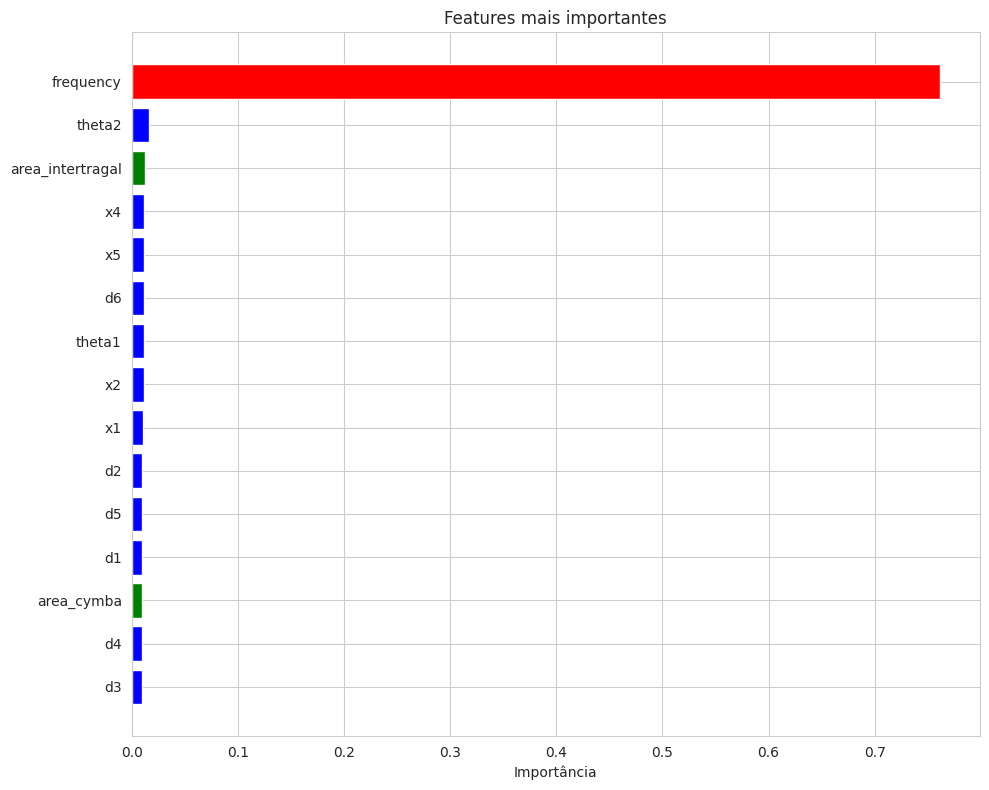

Top 10 features:
frequency: 0.7611
theta2: 0.0163
area_intertragal: 0.0130
x4: 0.0119
x5: 0.0118
d6: 0.0117
theta1: 0.0115
x2: 0.0114
x1: 0.0108
d2: 0.0103


In [8]:
# Calcular importância média
feature_names_with_freq = feature_cols + ['frequency']
importances = np.zeros(len(feature_names_with_freq))
n_models = 0

for (ear, pid), model in models.items():
    importances += model.feature_importances_
    n_models += 1

importances /= n_models

# Criar dataframe com importâncias
importance_df = pd.DataFrame({
    'feature': feature_names_with_freq,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualizar top 15 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)

# Cores por tipo de feature
colors = []
for f in top_features['feature']:
    if 'area' in f:
        colors.append('green')
    elif f == 'frequency':
        colors.append('red')
    else:
        colors.append('blue')

plt.barh(top_features['feature'], top_features['importance'], color=colors)
plt.xlabel('Importância')
plt.title('Features mais importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Listar top 10
print("Top 10 features:")
for i, row in importance_df.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

## 9. Análise por posição

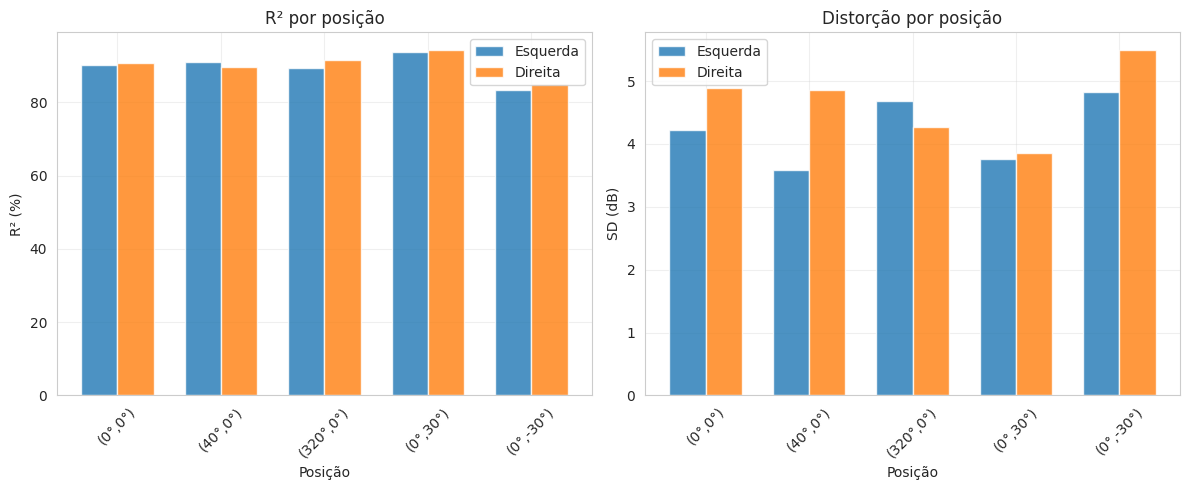

In [9]:
# Gráficos de desempenho por posição
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

positions = ['(0°,0°)', '(40°,0°)', '(320°,0°)', '(0°,30°)', '(0°,-30°)']
x = np.arange(len(positions))
width = 0.35

# R² por posição
ax1.bar(x - width/2, [r*100 for r in R2[0]], width, label='Esquerda', alpha=0.8)
ax1.bar(x + width/2, [r*100 for r in R2[1]], width, label='Direita', alpha=0.8)
ax1.set_xlabel('Posição')
ax1.set_ylabel('R² (%)')
ax1.set_title('R² por posição')
ax1.set_xticks(x)
ax1.set_xticklabels(positions, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# SD por posição
ax2.bar(x - width/2, SD[0], width, label='Esquerda', alpha=0.8)
ax2.bar(x + width/2, SD[1], width, label='Direita', alpha=0.8)
ax2.set_xlabel('Posição')
ax2.set_ylabel('SD (dB)')
ax2.set_title('Distorção por posição')
ax2.set_xticks(x)
ax2.set_xticklabels(positions, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Salvamento dos modelos

In [10]:
# Salvar modelos treinados
import pickle

os.makedirs('models', exist_ok=True)

# Salvar cada modelo
for (ear, pos_id), model in models.items():
    ear_name = 'left' if ear == 0 else 'right'
    filename = f'models/v3_{ear_name}_pos{pos_id}.pkl'
    
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

print(f"Modelos salvos: {len(models)} arquivos")

# Salvar metadados
metadata = {
    'version': '3.0',
    'features': feature_cols,
    'n_features': len(feature_cols),
    'positions': pos_tgt,
    'frequencies': tgt_freqs.tolist(),
    'r2_mean': overall_r2,
    'sd_mean': overall_sd
}

with open('models/v3_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Metadados salvos")

Modelos salvos: 10 arquivos
Metadados salvos


## 11. Conclusões

In [11]:
# Resumo final
print("RESULTADOS FINAIS")
print("="*50)

print(f"\nDesempenho:")
print(f"- R²: {np.nanmean(R2[0])*100:.1f}% (esquerda), {np.nanmean(R2[1])*100:.1f}% (direita)")
print(f"- SD: {np.mean([np.nanmean(SD[0]), np.nanmean(SD[1])]):.2f} dB")

print("\nCaracterísticas do modelo:")
print("- 23 features antropométricas + frequência")
print("- 10 modelos Random Forest (5 posições × 2 orelhas)")
print("- Melhor desempenho em elevações altas")
print("- Áreas calculadas são features críticas")

RESULTADOS FINAIS

Desempenho:
- R²: 89.5% (esquerda), 90.2% (direita)
- SD: 4.45 dB

Características do modelo:
- 23 features antropométricas + frequência
- 10 modelos Random Forest (5 posições × 2 orelhas)
- Melhor desempenho em elevações altas
- Áreas calculadas são features críticas
